# Error Estimation

In [8]:
import h5py
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")
from library import dspec

## Load Data

In [3]:
# data path
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2_AVG.h5"
xps_path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2_XPS.h5"

# load covariance data
with h5py.File(path, "r") as f:
    frq = f["FRQ"][()]
    lst = f["LST"][()]
    cov_xx = f["cov XX"][()]
    cov_yy = f["cov YY"][()]
    
# load cross-power spectral data
with h5py.File(xps_path, "r") as f:
    xps_xx = f["XPS XX"][()]
    xps_yy = f["XPS YY"][()]
    
Nlst = len(lst)
Ntrx = xps_xx.shape[0]
Ntry = xps_yy.shape[0]
Ndx = xps_xx.shape[-1]
Ndy = xps_yy.shape[-1]

## Compute Weights

In [4]:
w_xx = np.array([[1 / (cov_xx[:, i, i] * cov_xx[:, j, j]) for i in range(Ntrx)] for j in range(Ntrx)])
w_yy = np.array([[1 / (cov_yy[:, i, i] * cov_yy[:, j, j]) for i in range(Ntry)] for j in range(Ntry)])

## Compute Noise-only Power Spectrum Variance

In [ ]:
def noise_var(w, cov):
    w = w / w.sum()
    trange = 4 * (range(w.shape[0]),)
    for i, j, k, l in product(*trange):
        yield np.sum(w[i, j] * w[k, l] * cov[:, i, k] * cov[:, j, l])
        
var_xx = np.sum(np.fromiter(noise_var(w_xx, cov_xx), dtype=complex))
var_yy = np.sum(np.fromiter(noise_var(w_yy, cov_yy), dtype=complex))

In [29]:
print(var_xx / fs**2 * Ndx * 2)

[0.00562356+2.28362584e-17j 0.00354118-6.70083131e-18j
 0.00511492-2.99349665e-17j 0.00557948-1.55617265e-18j
 0.00561452-1.69474879e-17j 0.00441165+6.03710317e-18j
 0.00677088-2.19899252e-17j 0.00560225+8.56619580e-18j
 0.00782056-7.53247344e-18j 0.00927304-3.79844005e-17j
 0.01625528-9.54073352e-18j 0.0153825 -2.49158981e-17j
 0.0092213 +1.36707751e-17j 0.01068607-8.93568071e-18j
 0.00639827-1.95106914e-18j 0.00252657+1.04721612e-17j
 0.00280455+3.52359504e-18j 0.00073617-1.00468805e-17j
 0.00040439+8.39596715e-19j 0.00100948-2.84300166e-18j
 0.00223501+6.10925925e-18j 0.00051778-2.58842858e-19j
 0.00032168+2.33230520e-18j 0.00170701-1.46121740e-18j
 0.0029649 -2.12558480e-17j 0.00350261+6.15016089e-17j
 0.00198019-1.97295408e-18j 0.00195623+1.92708705e-17j
 0.00115428+2.61648111e-19j 0.00144131-1.29143556e-17j
 0.00221321+1.52404231e-17j 0.00334455-1.25392212e-18j
 0.00668086-3.52665609e-17j 0.00695498-1.63809353e-18j
 0.01630227+9.37752579e-17j 0.01052315-6.68785126e-17j
 0.0233019

In [21]:
fs = 10.24 * 1e-6
var_xx_norm = var_xx / fs**2 * Ndx * 2
var_yy_norm = var_yy / fs**2 * Ndy * 2

## Average Cross-Power Spectra

In [15]:
def avg_xps(xps, w):
    return (np.moveaxis(xps, -1, 0) * w).sum(axis=(1, 2, 3)) / w.sum(axis=(0, 1, 2))

xps_xx_avg = avg_xps(xps_xx, w_xx)
xps_yy_avg = avg_xps(xps_yy, w_yy)

In [23]:
print(var_xx_norm.sum())

(0.3771657502597997-1.3880316376119411e-16j)


## Plot

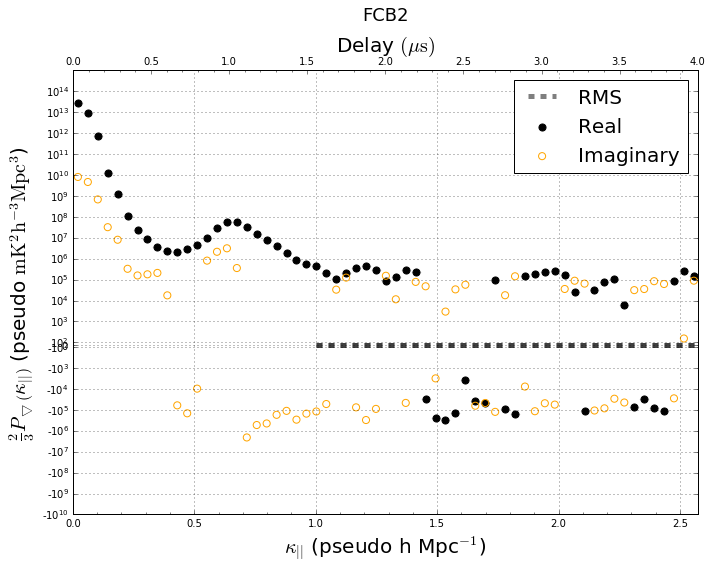

In [24]:
err_xx = np.ones_like(xps_xx_avg) * np.sqrt(var_xx_norm.sum())
delay = dspec.delay(n=Ndx)

dspec.power_plot(
    delay,
    xps_xx_avg, 
    err_xx,
    linthresh=1e3,
    legend=True,
    onesided=True,
    title="FCB2",
)